In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import skew
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
import os

In [5]:
import shutil

print("Please make sure you have downloaded your kaggle.json file from your Kaggle account.")

# Path where kaggle.json is currently located (adjust if needed)
source_path = "kaggle.json"   # keep this file in the same folder as your notebook
dest_dir = os.path.expanduser("~/.kaggle")
dest_path = os.path.join(dest_dir, "kaggle.json")

# Create .kaggle directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Move kaggle.json to ~/.kaggle
shutil.copy(source_path, dest_path)

# Set file permissions (only for Linux/Mac, ignored on Windows)
os.chmod(dest_path, 0o600)

print("\nKaggle API configured successfully.")


Please make sure you have downloaded your kaggle.json file from your Kaggle account.

Kaggle API configured successfully.


In [2]:
df = pd.read_csv('train.csv')
df2 = pd.read_csv('test.csv')

In [3]:
df.set_index('Id', inplace=True)
df2.set_index('Id', inplace=True)

In [22]:
df.shape, df2.shape

((1460, 80), (1459, 79))

In [23]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

### EDA

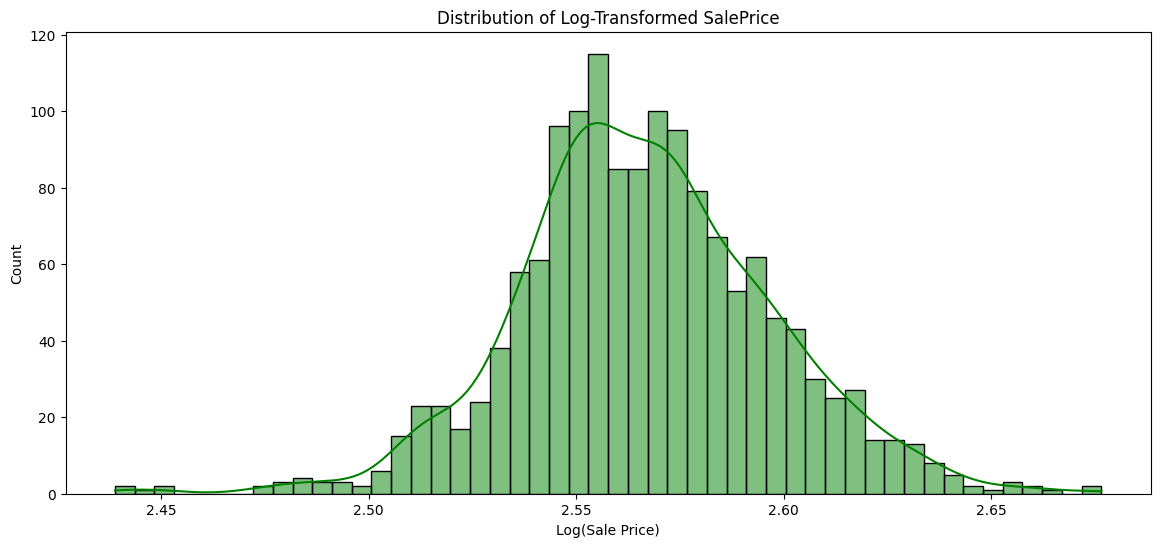

Skewness of Log-Transformed SalePrice: -0.00922874059690396


In [26]:
# Target variable: SalePrice

df['SalePrice'] = np.log1p(df['SalePrice'])

plt.figure(figsize=(14, 6))
sns.histplot(df['SalePrice'], kde=True, bins=50, color='green')
plt.title('Distribution of Log-Transformed SalePrice')
plt.xlabel('Log(Sale Price)')
plt.show()

print(f"Skewness of Log-Transformed SalePrice: {df['SalePrice'].skew()}")

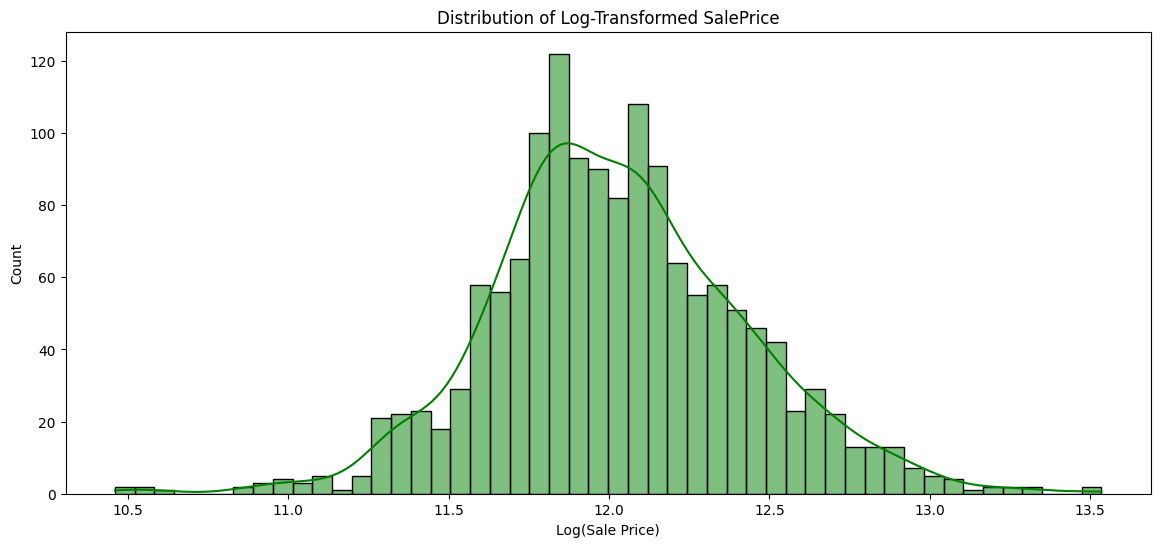

Skewness of Log-Transformed SalePrice: 0.12134661989685333


In [4]:
## Right Skewed Distribution
## Normalization done using log1p

df['SalePrice'] = np.log1p(df['SalePrice'])

plt.figure(figsize=(14, 6))
sns.histplot(df['SalePrice'], kde=True, bins=50, color='green')
plt.title('Distribution of Log-Transformed SalePrice')
plt.xlabel('Log(Sale Price)')
plt.show()

print(f"Skewness of Log-Transformed SalePrice: {df['SalePrice'].skew()}")

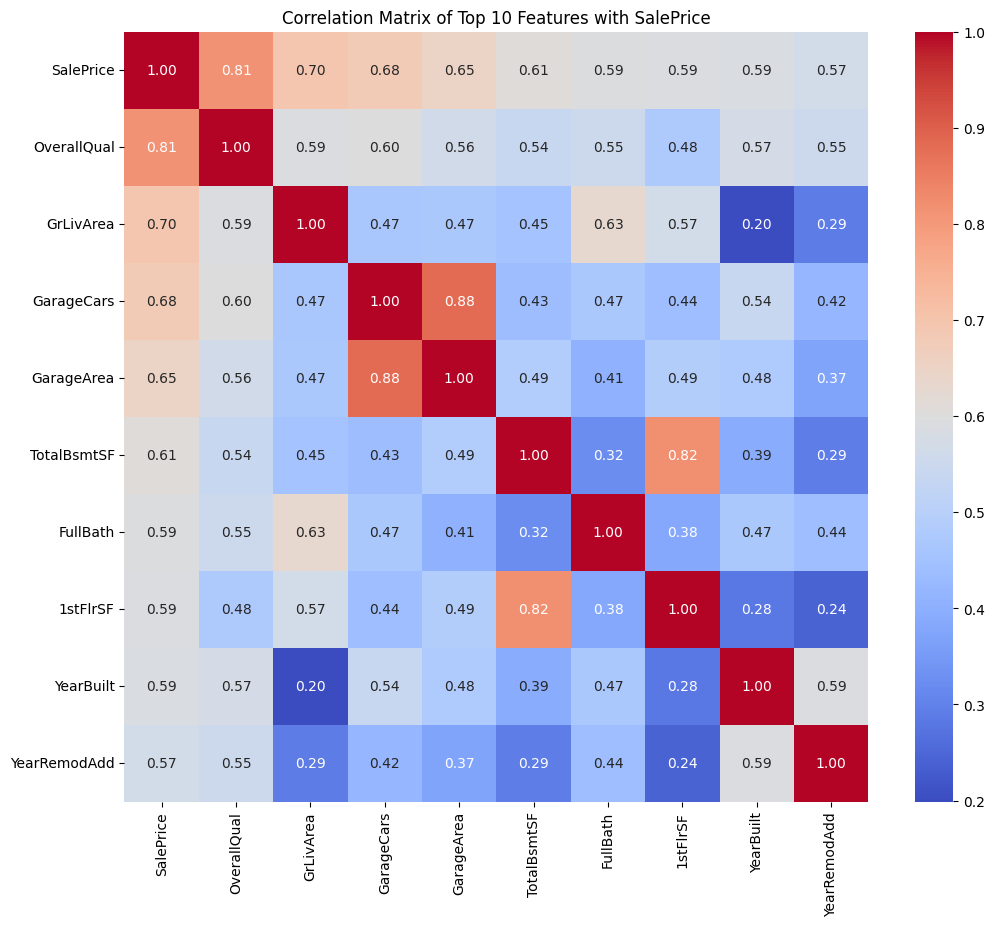

In [29]:
### Correlation Matrix
corrmat = df.corr(numeric_only=True)
top_corr_features = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
top_corr_matrix = df[top_corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Top 10 Features with SalePrice')
plt.show()

### Data Preprocessing

In [5]:
df3 = pd.concat((df.loc[:,:'SaleCondition'], df2.loc[:,:'SaleCondition']))

print(f"Combined data shape: {df3.shape}")

Combined data shape: (2919, 79)


In [6]:
missing = df3.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageYrBlt      159
GarageCond       159
GarageFinish     159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
Functional         2
BsmtHalfBath       2
Utilities          2
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
Electrical         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
KitchenQual        1
GarageArea         1
GarageCars         1
SaleType           1
dtype: int64

In [7]:
## Filling missing values with 0 in numerical columns

num_cols = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'BsmtFullBath', 'BsmtHalfBath']
for col in num_cols:
    if col in df3.columns:
        df3[col] = df3[col].fillna(0)


In [8]:
missing = df3.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MSZoning           4
Functional         2
Utilities          2
Exterior1st        1
Exterior2nd        1
Electrical         1
KitchenQual        1
SaleType           1
dtype: int64

In [9]:
## Filling missing values in 'LotFrontage' based on median of 'Neighborhood'
if 'LotFrontage' in df3.columns and df3['LotFrontage'].isnull().any():
    df3['LotFrontage'] = df3.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [18]:
df3['Alley'].value_counts()

Alley
Grvl    120
Pave     78
Name: count, dtype: int64

In [10]:
#Impute categorical features with 'None'
categorical_cols_to_impute_none = ['Alley', 'Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
for col in categorical_cols_to_impute_none:
    if col in df3.columns:
        df3[col] = df3[col].fillna('None')

for col in ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Utilities', 'Functional', 'MSZoning']:
    if col in df3.columns:
        df3[col] = df3[col].fillna(df3[col].mode()[0])

In [11]:
if 'GarageYrBlt' in df3.columns:
    df3['GarageYrBlt'] = df3['GarageYrBlt'].fillna(0)

In [12]:
print("\nMissing values after all imputation:", df3.isnull().sum().sum())


Missing values after all imputation: 0


#### Extracting Features

In [13]:
df3['TotalSF'] = df3['TotalBsmtSF'] + df3['1stFlrSF'] + df3['2ndFlrSF']


df3['TotalBath'] = (df3['FullBath'] + (0.5 * df3['HalfBath']) +
                         df3['BsmtFullBath'] + (0.5 * df3['BsmtHalfBath']))


df3['Age'] = df3['YrSold'] - df3['YearBuilt']

print("New features created.")

New features created.


In [14]:
df3['Neighborhood'].value_counts()

Neighborhood
NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Name: count, dtype: int64

In [15]:
# Turning categorical variables into dummy/indicator variables
cat_cols = df3.select_dtypes(include=['object']).columns
df3 = pd.get_dummies(df3, columns=cat_cols, drop_first=True)

print(f"Data shape after encoding: {df3.shape}")

Data shape after encoding: (2919, 262)


In [16]:
df3.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,False,False,False,False,True,False,False,False,True,False
2,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,False,False,False,False,True,False,False,False,True,False
3,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,False,False,False,False,True,False,False,False,True,False
4,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,False,False,False,False,True,False,False,False,False,False
5,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,False,False,False,False,True,False,False,False,True,False


### Model Training and Evaluation

In [17]:
x = df3.loc[:len(df)]
y = df['SalePrice']
x_test1 = df3[len(df.index):]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)
X_test_final = scaler.transform(x_test1)

In [37]:
x

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,False,False,False,False,True,False,False,False,True,False
2,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,False,False,False,False,True,False,False,False,True,False
3,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,False,False,False,False,True,False,False,False,True,False
4,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,False,False,False,False,True,False,False,False,False,False
5,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False
1457,20,85.0,13175,6,6,1978,1988,119.0,790.0,163.0,...,False,False,False,False,True,False,False,False,True,False
1458,70,66.0,9042,7,9,1941,2006,0.0,275.0,0.0,...,False,False,False,False,True,False,False,False,True,False


In [19]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [20]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror', # Corrected objective function
                        n_estimators=1000,
                        learning_rate=0.05,
                        max_depth=3,
                        min_child_weight=1,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42)


xgbr.fit(x_train, y_train)
y_pred_xgb = xgbr.predict(x_test)

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} Performance ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R-squared: {r2:.4f}\n")

evaluate_model(y_test,y_pred_xgb, "XGBoost")

--- XGBoost Performance ---
RMSE: 0.1335
MAE:  0.0860
R-squared: 0.9045



In [22]:
evaluate_model(y_test, y_pred, "Linear Regression") 

--- Linear Regression Performance ---
RMSE: 0.1734
MAE:  0.0960
R-squared: 0.8389



In [23]:
final_predictions_log = xgbr.predict(x_test1)

# IMPORTANT: We must reverse the log transformation to get the predictions back on the original price scale
final_predictions = np.expm1(final_predictions_log)

# Create the submission DataFrame
submission = pd.DataFrame({'Id': df2.index, 'SalePrice': final_predictions})

# Save to csv
submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully.")
submission.head()

Submission file 'submission.csv' created successfully.


,Id,SalePrice
0,1461,126339.335938
1,1462,162520.828125
2,1463,192386.312500
3,1464,192762.625000
4,1465,180384.046875
